# Muultiwavelength HDF5 input
Added by Shooby: Oct 24th

In [10]:
import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import astropy.wcs as wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import ndimage
from PIL import Image
import h5py


def radec2xy(ra,dec,wc):
    coords = SkyCoord(ra,dec, unit='deg')
    a=wcs.utils.skycoord_to_pixel(coords, wc, origin=0,mode=u'wcs')
    return a[0],a[1]
    
def cut(ra,dec,andaze,filename):
    '''gets coordinates of the galaxy and the filter to return a cutout
    (also called a postage stamp) of the galaxy with given size'''
    hdr = pyfits.getheader(filename)
    w = wcs.WCS(hdr)
    x,y=radec2xy(ra,dec,w)
    x,y=np.int(x),np.int(y)
    im=pyfits.getdata(filename)[y-andaze:y+andaze,x-andaze:x+andaze]
    return im

%matplotlib inline

In [110]:
gs = pyfits.getdata('../../WFIRST_WPS/CANDELS_fits/gds.fits')
sel1 = (gs['zbest']>0.01)&(gs['zbest']<2.0)&(gs['CLASS_STAR']<0.9)&(gs['Hmag']<25.)&(gs['ISOAREA_IMAGE_F160W']>=100)#&(gs['B_IMAGE_1']/gs['A_IMAGE_1']>0.6)
redshifts,ra1,dec1 = (gs['zbest'][sel1]),(gs['RA_1'][sel1]),(gs['DEC_1'][sel1])

print (len(gs[sel1]))

3156


Train data: 500/2000
Train data: 1000/2000
Train data: 1500/2000
Train data: 2000/2000


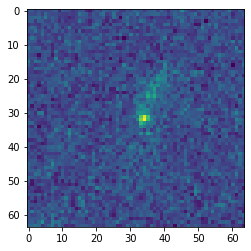

In [116]:
%rm 'Sample.hdf5'
train_shape = (2500, 7, 64, 64)
test_shape = (500, 7, 64, 64)
# open a hdf5 file and create earrays
hdf5_file = h5py.File('Sample.hdf5', mode='w')

hdf5_file.create_dataset("train_img", train_shape, np.int8)
hdf5_file.create_dataset("test_img", test_shape, np.int8)

hdf5_file.create_dataset("train_labels", (2500,), np.float32)
hdf5_file["train_labels"][...] = redshifts[:2500]

hdf5_file.create_dataset("test_labels", (500,), np.float32)
hdf5_file["test_labels"][...] = redshifts[2500:3000]


for i in range(2500):
    # print how many images are saved every 1000 images
    if i % 500 == 0 and i > 1:
        print ('Train data: {}/{}'.format(i, 2000))

        
    data = np.zeros((7,64,64))
    pashe = np.zeros((7,64,64))
    
    data[0,:,:] = cut(ra1[i],dec1[i],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f435w_060mas_v1.5_drz.fits')
    data[1,:,:] = cut(ra1[i],dec1[i],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f606w_060mas_v1.5_drz.fits')
    data[2,:,:] = cut(ra1[i],dec1[i],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f775w_060mas_v1.5_drz.fits')
    data[3,:,:] = cut(ra1[i],dec1[i],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f814w_060mas_v1.5_drz.fits')
    data[4,:,:] = cut(ra1[i],dec1[i],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f850l_060mas_v1.5_drz.fits')
    data[5,:,:] = cut(ra1[i],dec1[i],32,'/Users/shemmati/Desktop/GOODS/goodss_all_wfc3_ir_f125w_060mas_v1.0_drz.fits')
    data[6,:,:] = cut(ra1[i],dec1[i],32,'/Users/shemmati/Desktop/GOODS/goodss_all_wfc3_ir_f160w_060mas_v1.0_drz.fits')

    for chi in range(7):
        s = ndimage.rotate(data[chi,:,:],0,mode='nearest',reshape=False)
        da = np.arcsinh(s)
        pashe[chi,:,:] = (255.0 / (da.max()+0.1) * (da - da.min())).astype(np.uint8)
    
    # save the image and calculate the mean so far
    hdf5_file["train_img"][i, ...] = pashe

for i in range(500):
    j=i+2500
    # print how many images are saved every 1000 images
    if i % 500 == 0 and i > 1:
        print ('Test data: {}/{}'.format(i, 500))
        
    data = np.zeros((7,64,64))
    pashe = np.zeros((7,64,64))
    data[0,:,:] = cut(ra1[j],dec1[j],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f435w_060mas_v1.5_drz.fits')
    data[1,:,:] = cut(ra1[j],dec1[j],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f606w_060mas_v1.5_drz.fits')
    data[2,:,:] = cut(ra1[j],dec1[j],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f775w_060mas_v1.5_drz.fits')
    data[3,:,:] = cut(ra1[j],dec1[j],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f814w_060mas_v1.5_drz.fits')
    data[4,:,:] = cut(ra1[j],dec1[j],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f850l_060mas_v1.5_drz.fits')
    data[5,:,:] = cut(ra1[j],dec1[j],32,'/Users/shemmati/Desktop/GOODS/goodss_all_wfc3_ir_f125w_060mas_v1.0_drz.fits')
    data[6,:,:] = cut(ra1[j],dec1[j],32,'/Users/shemmati/Desktop/GOODS/goodss_all_wfc3_ir_f160w_060mas_v1.0_drz.fits')

    for chi in range(7):
        s = ndimage.rotate(data[chi,:,:],0,mode='nearest',reshape=False)
        da = np.arcsinh(s)
        pashe[chi,:,:] = (255.0 / (da.max()+0.1) * (da - da.min())).astype(np.uint8)
     
    
    # save the image and calculate the mean so far
    hdf5_file["test_img"][i, ...] = pashe


hdf5_file.close()

In [117]:
hf = h5py.File('Sample.hdf5', 'r')
hf.keys()


<KeysViewHDF5 ['test_img', 'test_labels', 'train_img', 'train_labels']>

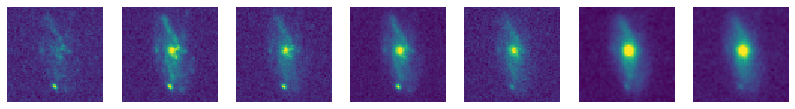

In [122]:
boz=np.random.randint(1,2500)
mm = hf['train_img'][boz, ...]
plt.figure(figsize=(14,3))
for i in range(7):
    plt.subplot(1,7,i+1)
    plt.imshow(mm[i,:,:],origin='lower')
    plt.axis('off')